# **OrieentiringGA: genetic algorithm for orieenting**

# Libraries import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Individual class definition

In [67]:
class Individual:

  '''
  This class represent an individual in the population for the GA

  Attributes:
    - path: a list that is used for storing the direction of the path
    - fitness: a variable used for saving the value of the fitness of the individual
    - number_of_cp_reached: a variable used for checking how many control points the individual has reached
    - cp_index: a dictionary used for checking at which number of steps the individual has reached a control point
  '''

  def __init__(self):
    '''
    Constructor of the Individual class: path is initialized as an empty list,
                                         fitness is initialized as 0,
                                         number_of_cp_reached is initialized as 0,
                                         cp_index is initialized with a single key:value element

    '''
    self.path = []
    self.fitness = 0
    self.number_of_cp_reached = 0
    self.cp_index = {0:0}

  # this method is used to retrieve the path of the individual
  def get_path(self):
    return self.path

  # this method is used to retrieve the fitness of the individual
  def get_fitness(self):
    return self.fitness

  # this method implements the concept of compass that each player can use to orient himself
  def compass(self,current_point,control_point):

    # the logic is very clear: given the (x,y) coordinate in which the player is
    # check in which direction go by comparing the next control point (x,y) coordinate


    if current_point[0] >= control_point[0] and current_point[1] >= control_point[1]:
      direction1 = 0
      direction2 = 1
    elif current_point[0] >= control_point[0] and current_point[1] <= control_point[1]:
      direction1 = 1
      direction2 = 2
    elif current_point[0] <= control_point[0] and current_point[1] <= control_point[1]:
      direction1 = 2
      direction2 = 3
    elif current_point[0] <= control_point[0] and current_point[1] >= control_point[1]:
      direction1 = 0
      direction2 = 3


    return direction1, direction2

  def __repr__(self):
        return "(Path: " + str(self.path) + ", fitness: " + str(self.fitness) + ", number_of_cp_reached: "+ str(self.number_of_cp_reached) + ", cp_index: " + str(self.cp_index) + ")"

# Map class definition

In [76]:
class Map:

  '''
  This class is used to create the map where the Orieentiring take place:
  it is a mxn array (m and n are given as parameter) where a certain number of
  obstacles and control points are placed.

  Attributes:
    - rows: the number of rows of the map (the m dimension)
    - colums: the numbers of the map (the n dimension)
    - number_of_obstacles: the number of obstacles that will appear on the map
    - number_of_cp: number of control points that will appear on the map
    - cp_list: a list containing all the coordinates of the control points.
               Initially contains the start point at (0,0)
  '''

  def __init__(self, rows, columns, number_of_obstacles, number_of_cp):

    '''
    The constructor of the map: lenght and height represent the dimension of the map (array)
    while number_of_obstacles and number_of_cp represent the number of obstacles and the number
    of control points that will be placed on the map, respectively.
    '''

    self.rows = rows
    self.columns = columns
    self.number_of_obstacles = number_of_obstacles
    self.number_of_cp = number_of_cp
    self.cp_list = []

  def create_map(self):

    '''
    This method is used to fill the array: the 'walkable ground' will be the cells that contains 0, the obstacle
    will be the cells containing 1 and the control points will be the cells contains 2, including the start and
    ending points.
    '''

    map_array = np.zeros((self.rows, self.columns)) #i nitially, we create a matrix with all 0s

    for i in range(self.number_of_obstacles): # iterate over the number of obstacles

      # randomically, create the coordinates where to put the obstacle
      x_obstacle = np.random.randint(0,self.rows)
      y_obstacle = np.random.randint(0,self.columns)

      # check if the coordinate corresponds with a control point, the start or the end
      if map_array[x_obstacle][y_obstacle] == 2:
        # if true, do not place the obstacle
        continue
      else:
        # else, place the obstacle
        map_array[x_obstacle][y_obstacle] = 1

      # next, place the control point
      if self.number_of_cp != 0:

        # randomically, create the coordinates where to put the control point
        x_cp = np.random.randint(0,self.rows)
        y_cp = np.random.randint(0,self.columns)

        # check if the control point is over an obstacle
        if map_array[x_cp][y_cp] == 1:
          # if true, do not put the control point
          continue
        else:
          map_array[x_cp][y_cp] = 2 # put the control point
          self.cp_list.append([x_cp,y_cp]) # add the coordinate to the list of all control points
          self.number_of_cp -= 1 # reduce the number of control points

    # I have decided to sort the control point vertically or horizontally based on a random number
    probability = np.random.uniform(0,1,1)

    if probability >= 0.5:
      self.cp_list.sort(key = lambda point: point[1])
    else:
      self.cp_list.sort()

    return map_array, self.cp_list # return the array and the list


  def getControlPointList(self):
    '''
    this method is used for obtain the list of control points
    '''
    return self.cp_list

  def visualizeMap(self,map):

    '''
    this method is used for plotting the map
    '''
    # set the dimension of the plot
    plt.figure(figsize=(12,12))

    #use a heatmap for plotting, so the same value will have the same color
    ax = sns.heatmap(map, cbar = False, cmap = sns.color_palette("coolwarm", 12),linewidth = 1)

    # get the x and y coordinate for each point, and sum 0.5, so the line will start at the centre of the square
    x = [self.cp_list[i][1] + 0.5 for i in range(len(self.cp_list))]
    y = [self.cp_list[i][0] + 0.5 for i in range(len(self.cp_list))]

    # plot the lines
    plt.plot(x, y, 'ro-')

    # add text near the point
    plt.text(x[0] - 0.15, y[0] - 0.15, 'Start')
    for i in range(1,len(x)-1):
      plt.text(x[i] + 0.15, y[i] + 0.15, str(i))
    plt.text(x[-1] - 0.20, y[-1] - 0.20, 'End')

    ax.invert_yaxis()

    plt.ylim(0,self.rows)
    plt.xlim(0,self.columns)

    # show the plot
    plt.show()

  def visualizeIndividual(self, map, individual):

    '''
    This method is used to visualize an individual on the map
    '''

    map_copy = map.copy() # make a copy of the map
    moves = [[0, -1], [-1, 0], [0, 1], [1, 0]]
    point = self.getControlPointList()[0] # get the starting point

    for m in individual.path: # follow the individual path
      point = [point[0] + moves[m][0], point[1] + moves[m][1]]

      if point[0] >= self.rows or point[1] >= self.columns or point[0] < 0 or point[1] < 0: # check if the path leads out of the map
        point = [point[0] - moves[m][0], point[1] - moves[m][1]] # if yes go back
        continue

      # here we change the value of the cell the individual moves on, so they will appear of a different color when we call the method
      # we change color also when the individual finds a control point
      if map_copy[point[0]][point[1]] == 2:
        map_copy[point[0]][point[1]] = 3
      else:
        map_copy[point[0]][point[1]] = 3

    plt.figure(figsize=(12,12))

    ax = sns.heatmap(map_copy, cbar = False, cmap = sns.color_palette("coolwarm", 12),linewidth = 1)
    ax.invert_yaxis()

    x = [self.cp_list[i][1] + 0.5 for i in range(len(self.cp_list))]
    y = [self.cp_list[i][0] + 0.5 for i in range(len(self.cp_list))]

    # plot the lines
    plt.plot(x, y, 'ro-')

    # add text near the point
    plt.text(x[0] - 0.25, y[0] - 0.25, 'Start')
    for i in range(1,len(x)-1):
      plt.text(x[i] + 0.15, y[i] + 0.15, str(i))
    plt.text(x[-1] - 0.20, y[-1] - 0.20, 'End')

    plt.ylim(0,self.rows)
    plt.xlim(0,self.columns)

    # show the plot
    plt.show()

# Function to get the number of steps (distance) between two control points

In [14]:
def getNumberOfStepBetweenPoits(p1, p2):

  return (abs(p1[0] - p2[0])) + abs((p1[1] - p2[1])) # return the sum of the difference of points coordinates

# Function to get minimun number of steps between the start and end, passing through each control point

In [15]:
def getTotalNumberOfSteps(list_of_point):

  total_steps = 0 # initialize a variable that will count the total number of steps

  for i in range(0,len(list_of_point)-1): # iterate over the control points

    # for each control point get the distance between itself and the next and sum them up
    total_steps += getNumberOfStepBetweenPoits(list_of_point[i],list_of_point[i+1])

  return total_steps # return the total number of steps between the starting point and the ending point

# Function used to avoid exit the border of the map

In [17]:
def checkOutOfMap(point):

  # compare the coordiates of the current point the individual is upon with the matrix dimension (map limit)
  if point[0] < 0 or point[1] < 0 or point[0] > map.rows -1 or point[1] > map.columns - 1:
    return True

  return False

# Function used to check if where the individual is arrived is an obstacle

In [18]:
def checkObstacle(point):

  # compare the value of the cell given by the point coordinate with the obstacle variable
  if mappa[point[0]][point[1]] == 1:
    return True

  return False

# Function used to check if where the individual is arrived is a control point

In [19]:
def checkControlPoint(point, cp):

  # compare the coordinate of the point in which the individual is with the given control point coordinate
  if point[0] == cp[0] and point[1] == cp[1]:
    return True

  return False

# Function used to avoid obstacles

In [16]:
def avoid_obstacle(moves, current_point, movement):

  # create a boolean variable and set it to false
  found = False
  # get the coordinate where the individual where before stambling on an obstacle
  current_point = [current_point[0] - movement[0], current_point[1] - movement[1]]
  # from all the available moves, remove the one that lead the individual over the obstacle
  remain_moves = moves.copy()
  remain_moves.remove(movement)

  # iterate over the remain moves
  for points in remain_moves:
    # calculate the new point
    point = [current_point[0] + points[0], current_point[1] + points[1]]

    # check if this new movement get the individual out of the map
    if checkOutOfMap(point):
      # if true, move the next available moves
      continue

    # check if the new movement get the individual over an obstacle
    if checkObstacle(point):
      # if true, move the next available moves
      continue
    else:
      # set the current point as the new point reached with the new movement
      current_point = point
      # set the boolean variable as true
      found = True
      # return the new point, the boolean variable and the new movement
      return current_point, found, points

# Function used to create the initial population

In [22]:
def initPopulation(population_dim):

  population = [] # create an empty list that will contain the individuals
  cp_list = map.getControlPointList() # get the list of control points coordinates
  moves = [[0, -1], [-1, 0], [0, 1], [1, 0]] # available moves

  for ind in range(population_dim): # for each individual:
    number_of_cp_reached = 0 # initialize the number of control point reached as 0
    reached = False # initialize a random variable that is used to indicate that an individual has reached or not a control point
    blocked = False # initialize a random variable that is used to indicate that an individual has reached or not an obstacle
    individual = Individual() # create an Individual object
    current_point = cp_list[0] # get the first control point coordinate and set it as the current point (this is the starting point)
    steps = 0 # set the number of steps to 0

    for i in range(1, len(cp_list)): # iterate over the control points number
      reached = False
      control_point = cp_list[i] # get the coordinates of the next control point

      while not reached: # while the individual has not reached the control point

        if steps % 3 == 0: # every 3 steps the individial use the compass to orient itself toward the actual control point
          d1,d2 = individual.compass(current_point, control_point)
          movement = random.choice([moves[d1],moves[d2]])
        else:
          # otherwise the individual moves randomically selecting a move
          movement = random.choice(moves)

        individual.path.append(moves.index(movement)) # add to the individual path the index of the move selected
        steps += 1 # increment the number of steps of the individual by one
        current_point = [current_point[0] + movement[0], current_point[1] + movement[1]] # update the current position of the individual

        # check if the new point is out of the map
        if checkOutOfMap(current_point):
          # if yes, go back, remove the index from the path and decrease by 1 the steps taken by the individual
          current_point = [current_point[0] - movement[0], current_point[1] - movement[1]]
          individual.path.pop()
          steps -= 1

        # check if the new point is an obstacle
        if checkObstacle(current_point):
          # if yes avoid it, using the avoid_obstacle function
          current_point, found, new_movement = avoid_obstacle(moves, current_point, movement)
          steps -= 1 # decrease the total number of steps

          # check if the individual has found a way to avoid the obstacle
          if found:
            # if yes, then we remove from its path the old move and add the new one, used to avoid the obstacle
            individual.path.pop()
            individual.path.append(moves.index(new_movement))
            steps += 1 # increase the number of steps, because the individual has moved into a new direction
          else:
            # if cannot find a way, stop the loop for this individual
            blocked = True
            break

        # check if the new point is the control point
        if checkControlPoint(current_point, control_point):
          # if yes increment the number of control point reached by 1 and set it to the Individual variable
          number_of_cp_reached += 1
          individual.number_of_cp_reached = number_of_cp_reached
          individual.cp_index[i] = steps # set the total number of steps used to reach the control point
          reached = True # change the variable so the individual will now search the next control point

      # if the individual is blocked, stop the loop
      if blocked:
        break

    # after the loop, if the individual was blocked (and hasn't reached all the control points)
    if individual.number_of_cp_reached != len(cp_list) - 1:
      # set its fitness to infinite
      individual.fitness = np.inf
    else:
      # otherwise, set its fitness as the ration between the steps has used and the optimal one
      individual.fitness = steps/optimal_steps

    # add the individual to the population list
    population.append(individual)

  #return the population list
  return population

# Function used to compute the fitness of an individual

In [23]:
def findIndividualFitness(individual):

  moves = [[0, -1], [-1, 0], [0, 1], [1, 0]]
  point = map.getControlPointList()[0]
  steps = 0

  for m in individual.path: # loop over the individual path to get the number of steps of the individual
    point = [point[0] + moves[m][0], point[1] + moves[m][1]]
    steps += 1

    if checkOutOfMap(point):
      point = [point[0] - moves[m][0], point[1] - moves[m][1]]
      steps -= 1

    if checkObstacle(point):
      steps -= 1

  # compute the individual fitness as ration between number of its steps and the optimal ones
  individual.fitness = steps/optimal_steps

# Function used to compute the fitness for all the population

In [25]:
def findFitness(population):

  # for every individual in the population, compute its fitness by using the findIndividualFitness function
  for individual in population:

    findIndividualFitness(individual)

# Function used to rank the individual by the fitness in increasing order

In [26]:
def rankPopulation(population):

  # sort the population by the fitness in increasing order
  return sorted(population, key = lambda individual: individual.fitness)

# Function used to implement the Roulette Wheel selection

In [47]:
def rouletteWheelSelection(population_ranked):
    total_fitness = sum([1 / individual.fitness for individual in population_ranked])
    individual_probabilities = [(1 / individual.fitness) / total_fitness for individual in population_ranked]

    cumulative_probabilities = [individual_probabilities[0]]
    for value in individual_probabilities[1:]:
        cumulative_probabilities.append(cumulative_probabilities[-1] + value)

    random_number = np.random.uniform(0, 1)

    for i, value in enumerate(cumulative_probabilities):
        if random_number < value:
            return population_ranked[i]

    # Nel caso il random_number sia esattamente 1, restituisce l'ultimo individuo
    return population_ranked[-1]

# Function used to create the mating pool

In [48]:
def matingPool(population_ranked):

  mating_pool = []

  for i in range(len(population_ranked)):

    selected_individual = rouletteWheelSelection(population_ranked)
    population_ranked.remove(selected_individual)
    mating_pool.append(selected_individual)

  return mating_pool

# Function used to get the path to a specific control point

In [29]:
def retrievePathToCP(individual, cp):

  i = individual.cp_index.get(cp)
  return individual.path[:i]

# Function used to get the path from a specific control point to the arrival point

In [30]:
def retrievePathToEnd(individual,cp):

  i = individual.cp_index.get(cp)
  return individual.path[i:]

# Function used to compute the number of steps used to reach each control point

In [31]:
def calculateCPIndex(individual):

  moves = [[0, -1], [-1, 0], [0, 1], [1, 0]]
  steps = 0
  i = 1
  cp_list = map.getControlPointList()
  point = cp_list[0]

  for movement in individual.path:

    point = [point[0] + moves[movement][0], point[1] + moves[movement][1]]
    steps += 1
    if checkOutOfMap(point):
      point = [point[0] - moves[movement][0], point[1] - moves[movement][1]]
      steps -= 1

    if checkObstacle(point):
      steps -= 1

    if checkControlPoint(point,cp_list[i]):
      individual.cp_index[i] = steps
      i += 1

# Function used for reproduction

In [72]:
def reproduce(parent1, parent2):

  child = Individual()

  cp_index = random.randint(1,len(map.getControlPointList()) - 2)

  a = retrievePathToCP(parent1,cp_index)
  b = retrievePathToEnd(parent2,cp_index)

  child.path = a + b
  child.number_of_cp_reached = parent1.number_of_cp_reached

  for i in range(1,cp_index+1):
    child.cp_index[i] = parent1.cp_index.get(i)

  for i in range(cp_index+1,len(map.getControlPointList())):
    diff = parent2.cp_index.get(i) - parent2.cp_index.get(i-1)
    v = child.cp_index.get(i-1) + diff
    child.cp_index[i] = v

  return child

# Function used to reproduce the entire population

In [33]:
def reproducePopulation(mating_pool):

  children = []

  for i in range(0,len(mating_pool)-1,2):

    child = reproduce(mating_pool[i],mating_pool[i+1])
    children.append(child)

  return children

# Function used to get the path between two control points

In [34]:
def getPathBetweenCP(individual, index):

  i = individual.cp_index.get(index-1)
  j = individual.cp_index.get(index)

  return i,j,individual.path[i:j]

# Function for doing the swapping

In [55]:
def swap(path):

  i = random.randint(0,len(path)-1)
  j = random.randint(0,len(path)-1)

  path[i], path[j] = path[j],path[i]
  return path

# Function to mutate an individual

In [56]:
def mutateIndividual(individual):
  cp_index = random.randint(1,len(map.getControlPointList())-1)
  i,j,path = getPathBetweenCP(individual, cp_index)

  shuffled_path = swap(path)
  j = i + len(shuffled_path)
  individual.path = individual.path[:i] + shuffled_path + individual.path[j:]

# Function to mutate the population

In [39]:
def mutatePopulation(population, mutation_rate):

  for individual in population:

    index = np.random.uniform(0,1)

    if index < mutation_rate:

      mutateIndividual(individual)

# Function used to create the next population

In [40]:
def nextPopulation(actualPopulation, mutation_rate):

  ranked_pop = rankPopulation(actualPopulation)


  mating_pool = matingPool(ranked_pop)
  next_population = reproducePopulation(mating_pool)
  mutatePopulation(next_population,mutation_rate)
  findFitness(next_population)

  return next_population

# Function used to execute the genetic algorithm

In [69]:
def geneticAlgorithm(pop_dim, iteration, mutation_rate):

  pop = initPopulation(pop_dim)
  for i in range(iteration):
    pop = nextPopulation(pop, mutation_rate)

    if len(pop) < 5:
      break

  return pop

# Function used to get best indiviual

In [80]:
def getBestIndividual(population):
    # sort the final population in increasing order
    sorted_population = sorted(population, key=lambda individual: individual.fitness)

    # return the first element of the sorted population
    return sorted_population[0]

# Map creation

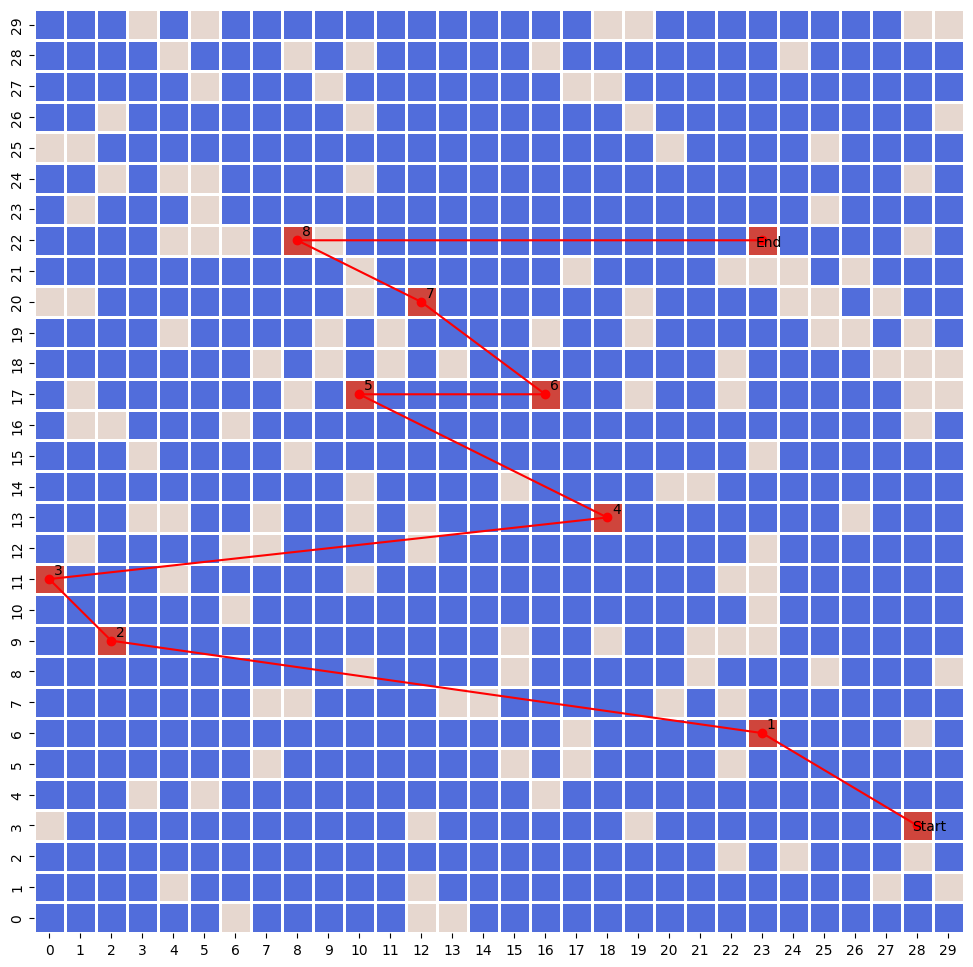


 Control points coordinates:


[[3, 28],
 [6, 23],
 [9, 2],
 [11, 0],
 [13, 18],
 [17, 10],
 [17, 16],
 [20, 12],
 [22, 8],
 [22, 23]]

In [97]:
map = Map(30,30,150,10)
mappa, lanterne = map.create_map()
map.visualizeMap(mappa)
print('\n Control points coordinates:')
cp_list = map.getControlPointList()
cp_list

# Genetic algorithm

In [ ]:
optimal_steps = getTotalNumberOfSteps(cp_list)

In [98]:
pop = geneticAlgorithm(7000,250,0.1)

# Get best individual

In [99]:
best = getBestIndividual(pop)

# Visualize the best individual

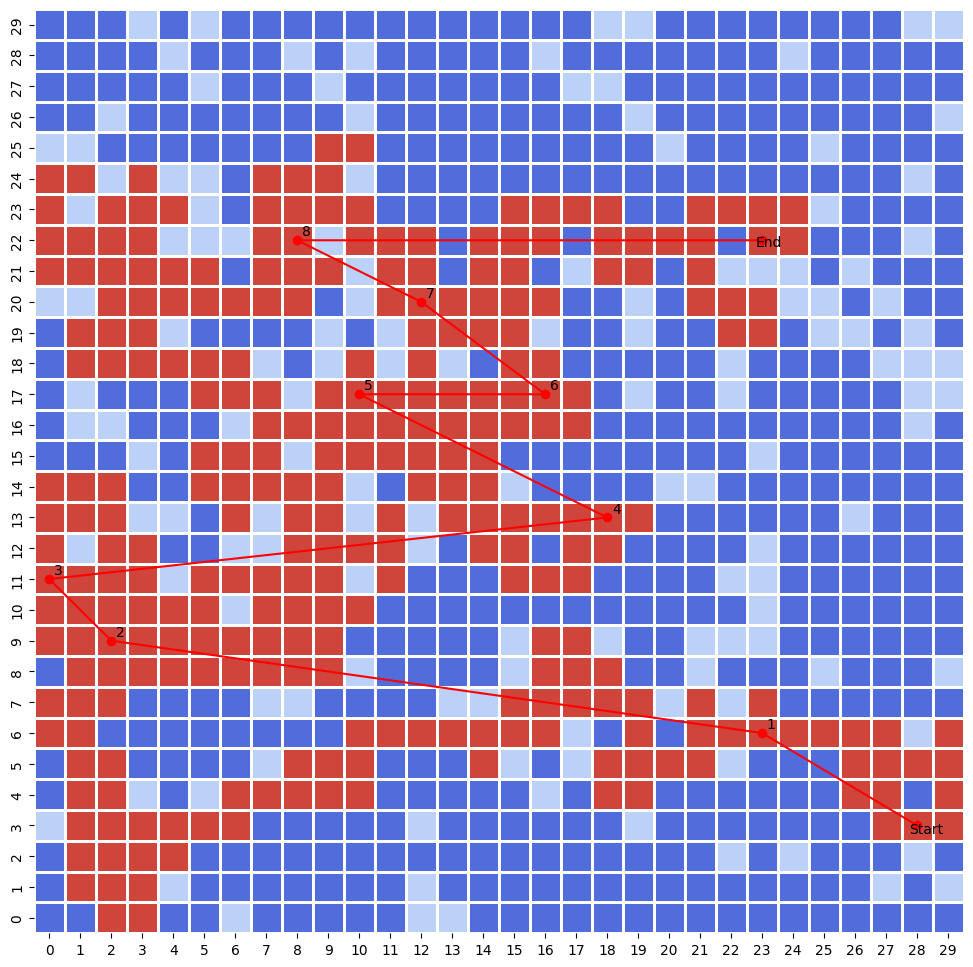

In [100]:
map.visualizeIndividual(mappa,best)